In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [68]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE

In [53]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [96]:
from neuralprophet import NeuralProphet

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
df = pd.read_csv('data/us_energy.csv', parse_dates=['date'], index_col=['date']) / 100

In [5]:
df.head()

,value
date,
1973-01-01,1.60218
1973-01-31,1.43539
1973-03-02,1.48158
1973-04-02,1.39589
1973-05-02,1.47395


In [6]:
skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 486    │ │ float64     │ 1     │                                    │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                    │
│ └───────────────────┴────────┘                                                            │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃        ┃ missing  ┃ complete rate  ┃ mean  ┃ sd    ┃ p0  ┃ p25 ┃ p75 ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ value  │        0 │              1 │   2.6 │  0.69 │ 1.4 │   2 │ 3.1 │  4.2 │ ▆▆▆█▄▁ │  │
│ └────────┴──────────┴────────────────┴───────┴───────┴─────┴─────┴─────┴──────┴────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

<AxesSubplot:xlabel='date'>

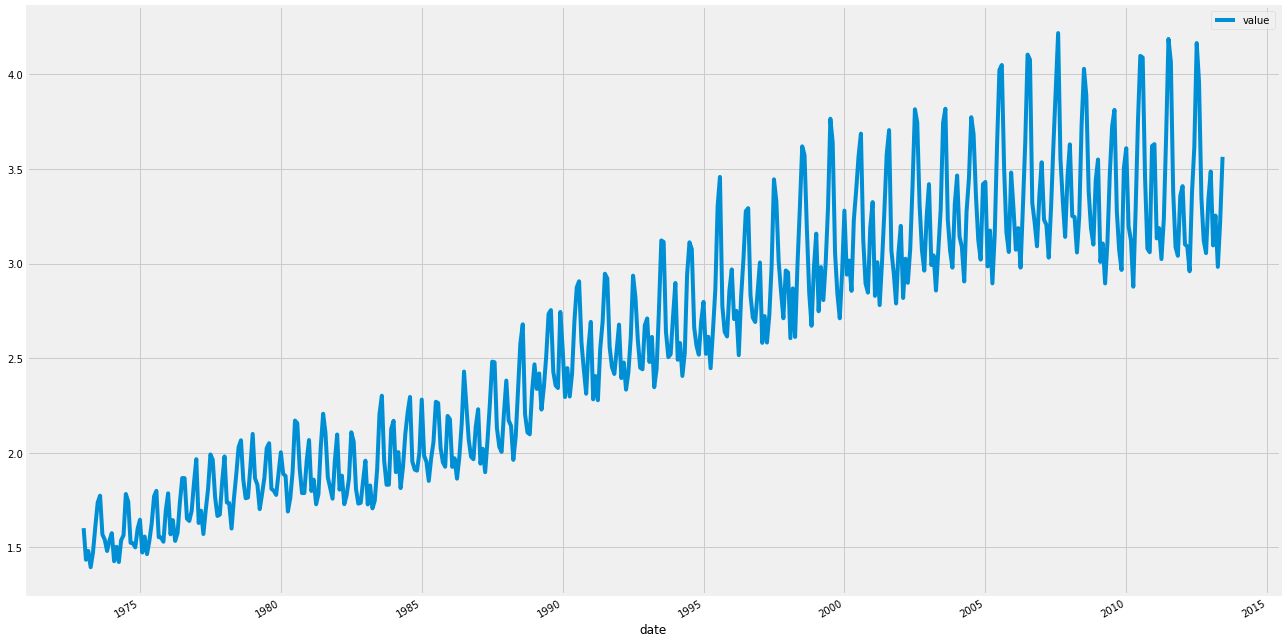

In [7]:
df.plot(figsize=(20, 12))

In [8]:
decomposition = seasonal_decompose(df, model='addaptive', period=12)

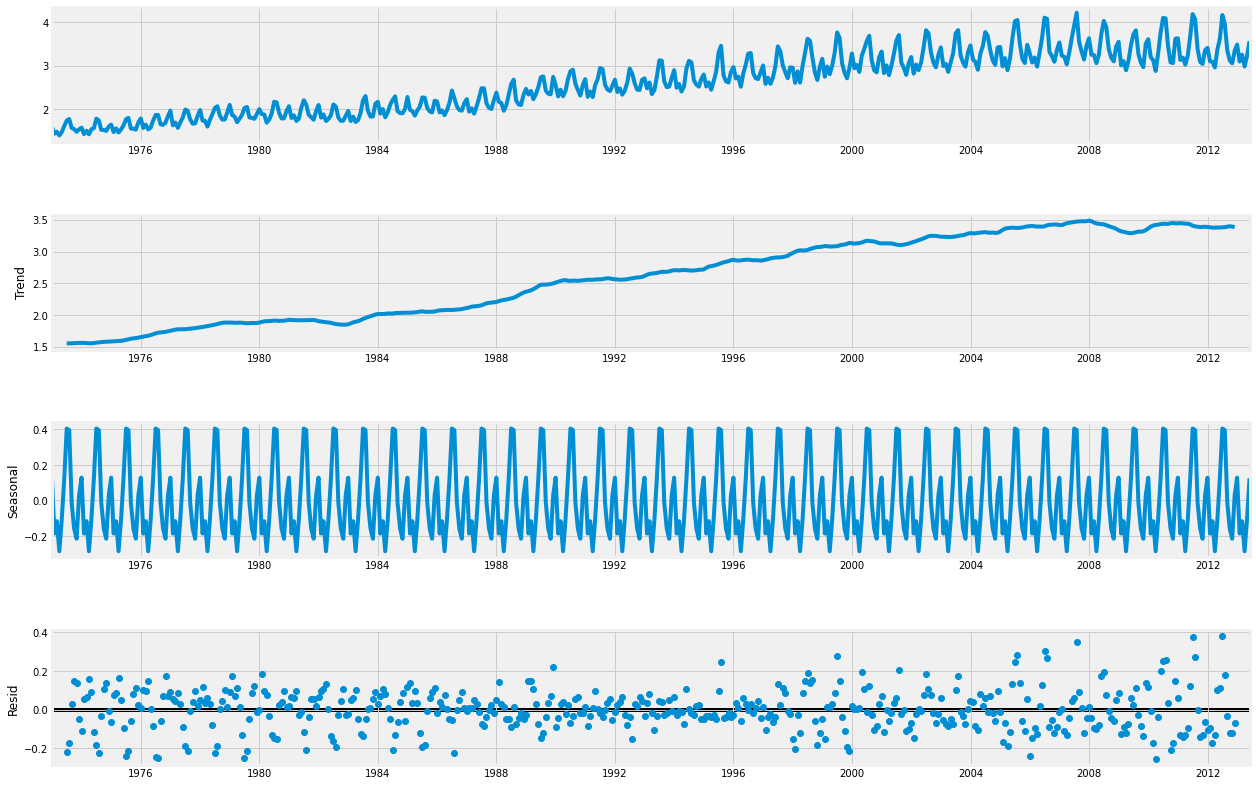

In [9]:
fig = decomposition.plot()
fig.set_size_inches(20, 12)

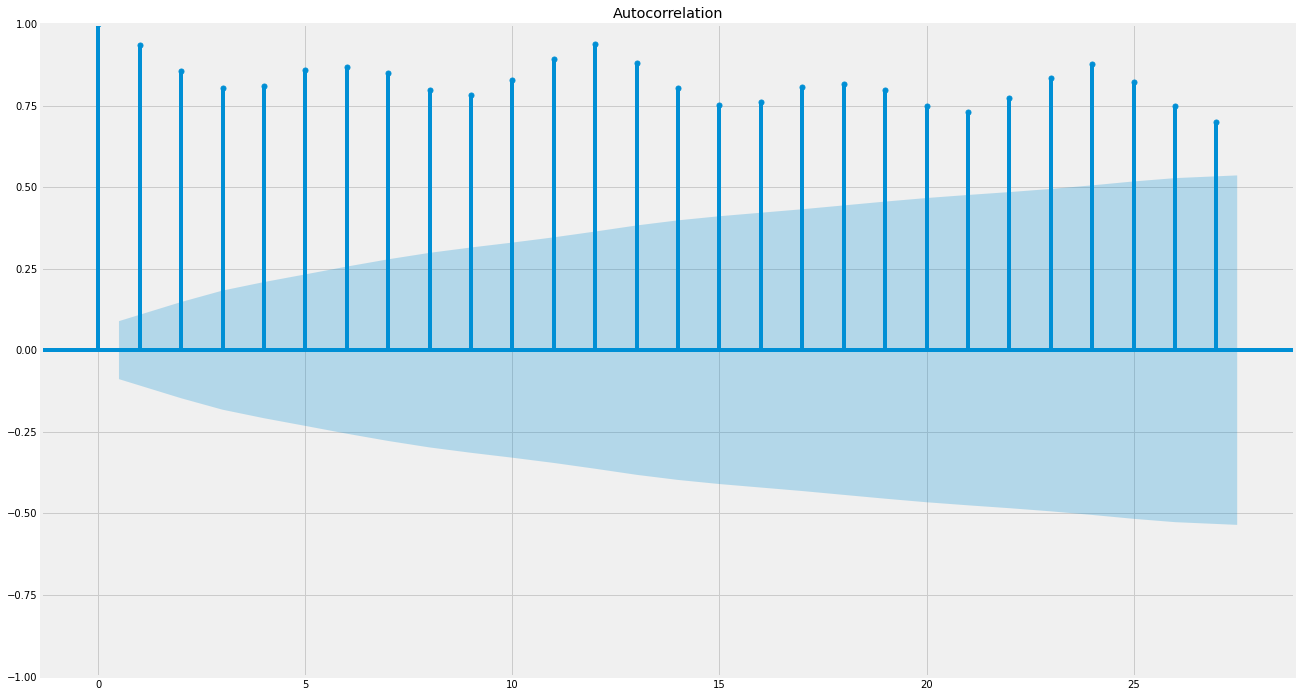

In [10]:
fig = plot_acf(df)
fig.set_size_inches(20, 12)

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


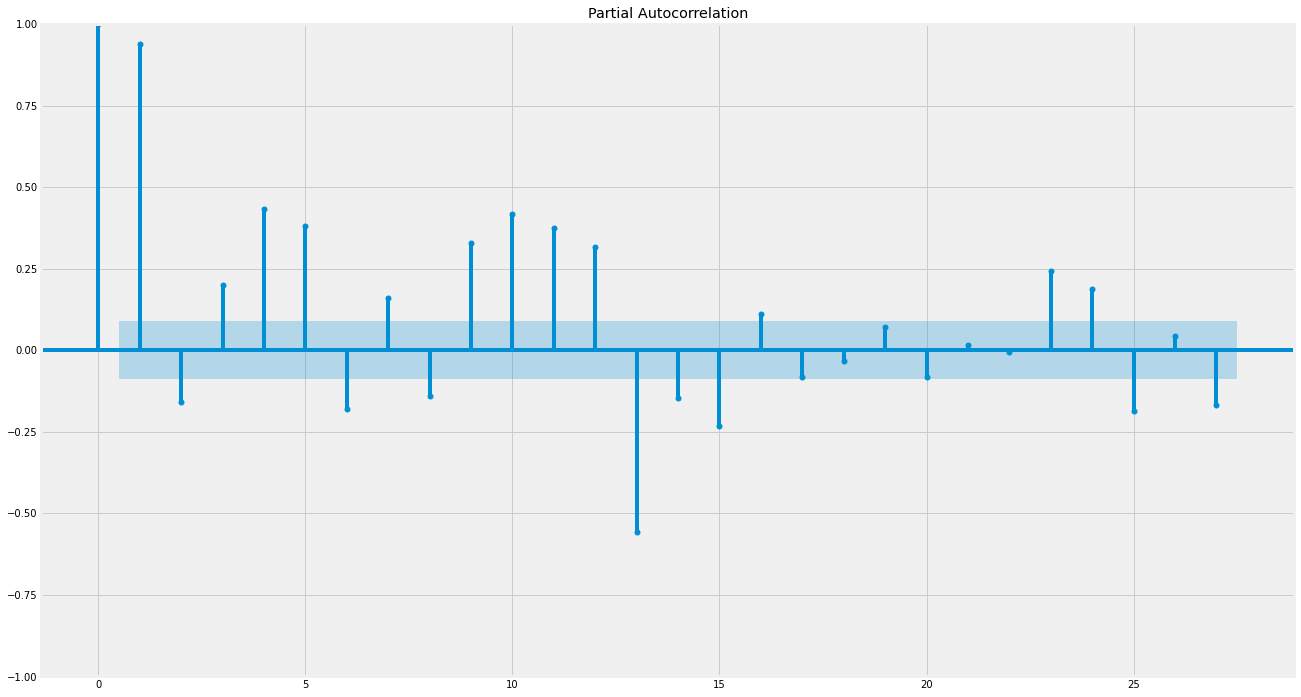

In [11]:
fig = plot_pacf(df)
fig.set_size_inches(20, 12)

In [12]:
cutoff_date = '2005-12-31'
train_ds, valid_ds = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
train_ds.shape, valid_ds.shape

((397, 1), (89, 1))

In [13]:
fit_1 = ExponentialSmoothing(train_ds['value'].to_numpy(), seasonal_periods=12, trend='mul', seasonal='mul').fit()

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [14]:
prediction_1 = fit_1.forecast(valid_ds.shape[0]).copy()
resid_1 = valid_ds['value'] - prediction_1

In [15]:
resid_1.describe()

count    89.000000
mean     -0.281371
std       0.218167
min      -0.690569
25%      -0.441245
50%      -0.294931
75%      -0.081889
max       0.134004
Name: value, dtype: float64

<AxesSubplot:xlabel='date'>

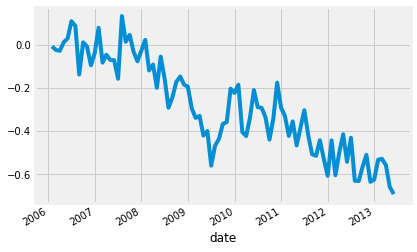

In [16]:
resid_1.plot()

<AxesSubplot:ylabel='Density'>

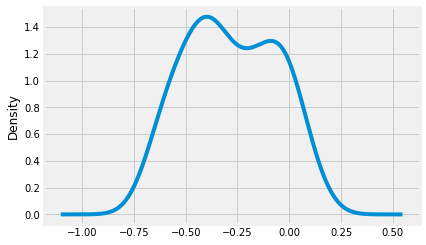

In [17]:
resid_1.plot(kind='kde')

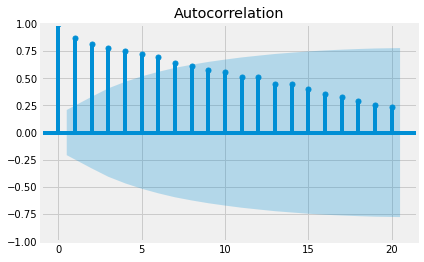

In [18]:
plot_acf(resid_1);

/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


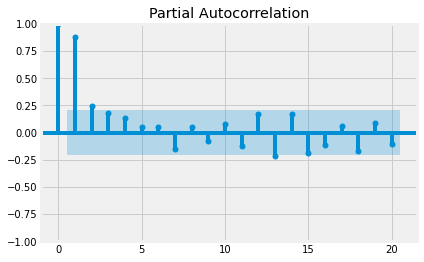

In [19]:
plot_pacf(resid_1);

In [20]:
fit_1.params_formatted

,name,param,optimized
smoothing_level,alpha,2.817337e-01,True
smoothing_trend,beta,2.282012e-17,True
smoothing_seasonal,gamma,2.263638e-01,True
initial_level,l.0,1.516744e+00,True
initial_trend,b.0,1.001948e+00,True
initial_seasons.0,s.0,1.068680e+00,True
initial_seasons.1,s.1,9.413292e-01,True
initial_seasons.2,s.2,9.666175e-01,True
initial_seasons.3,s.3,8.982857e-01,True
initial_seasons.4,s.4,9.486133e-01,True


In [70]:
cols_1 = ['time', 'Tair']
cols_2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']

whole_df = (
    pd.read_csv('data/GreenhouseClimate1.csv', usecols=cols_1 + cols_2)
    .assign(time=lambda df_: pd.to_datetime(df_['time'], unit='D', origin='1899-12-30'))
    .resample('H', on='time')
    .mean()
    .reset_index()
    .dropna(subset=['Tair'])
)

In [71]:
whole_df.head()

,time,Tair,assim_sp,co2_sp,dx_sp,int_blue_sp,int_farred_sp,int_red_sp,int_white_sp,scr_blck_sp,scr_enrg_sp,t_grow_min_sp,t_heat_sp,t_rail_min_sp,t_vent_sp,water_sup_intervals_sp_min,window_pos_lee_sp
0,2019-12-16 00:00:00,21.391667,NaN,NaN,NaN,0.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-16 01:00:00,20.823077,NaN,NaN,NaN,0.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-16 02:00:00,21.100000,NaN,NaN,NaN,0.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-16 03:00:00,20.900000,NaN,NaN,NaN,0.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-16 04:00:00,20.976923,NaN,NaN,NaN,0.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
skim(whole_df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 3983   │ │ float64     │ 16    │                                    │
│ │ Number of columns │ 17     │ │ datetime64  │ 1     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃             ┃ missing ┃ complete    ┃ mean ┃ sd   ┃ p0  ┃ p25 ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┃             ┃         ┃ rate        ┃      ┃      ┃     ┃     ┃      ┃      ┃        ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Tair        │       0 │           1 │   21 │    3 │  12 │  19 │   23 │   35 │   ▅█▃  │  │
│ │ assim_sp    │      39 │        0.99 │   58 │   48 │   0 │   0 │  100 │  100 │ ▆    █ │  │
│ │ co2_sp      │      38 │        0.99 │  720 │  200 │ 300 │ 470 │  900 │  930 │ ▂▃▁▁▂█ │  │
│ │ dx_sp       │      39 │        0.99 │  3.5 │  1.7 │   1 │ 2.3 │    4 │  8.3 │ ▄█▃▁▁▁ │  │
│ │ int_blue_sp │       0 │           1 │  2.2 │   39 │   0 │   0 │    0 │ 1000 │   █    │  │
│ │ int_farred_ │       0 │           1 │  470 │  490 │   0 │   0 │ 1000 │ 1000 │ █    ▇ │  │
│ │ sp          │         │             │      │      │     │     │      │      │        │  │
│ │ int_red_sp  │       0 │           1 │  490 │  490 │   0 │   0 │ 1000 │ 1000 │ █    █ │  │
│ │ int_white_s │       0 │           1 │  470 │  490 │   0 │   0 │ 1000 │ 1000 │ █    ▇ │  │
│ │ p           │         │             │      │      │     │     │      │      │        │  │
│ │ scr_blck_sp │      39 │        0.99 │   52 │   47 │   0 │   0 │   99 │  100 │ ▇    █ │  │
│ │ scr_enrg_sp │      39 │        0.99 │ 0.52 │  6.9 │   0 │   0 │    0 │   95 │   █    │  │
│ │ t_grow_min_ │     100 │        0.97 │   15 │   16 │   0 │   0 │   30 │   40 │ █  ▁▅▂ │  │
│ │ sp          │         │             │      │      │     │     │      │      │        │  │
│ │ t_heat_sp   │      38 │        0.99 │   20 │  2.2 │  10 │  18 │   22 │   25 │   ▂█▆▁ │  │
│ │ t_rail_min_ │      39 │        0.99 │   17 │   17 │   0 │   0 │   35 │   40 │ █   ▄▄ │  │
│ │ sp          │         │             │      │      │     │     │      │      │        │  │
│ │ t_vent_sp   │      38 │        0.99 │   21 │  2.6 │  13 │  19 │   23 │   35 │   ▆█▃  │  │
│ │ water_sup_i │      82 │        0.98 │  720 │  540 │  10 │  65 │ 1000 │ 2000 │ ▅ █  ▁ │  │
│ │ ntervals_   │         │             │      │      │     │     │      │      │        │  │
│ │ window_pos_ │      39 │        0.99 │ 0.65 │ 0.85 │   0 │   0 │  1.1 │    3 │ █ ▂▁▂  │  │
│ │ lee_sp      │         │             │      │      │     │     │      │      │        │  │
│ └─────────────┴─────────┴─────────────┴──────┴──────┴─────┴─────┴──────┴──────┴────────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃       ┃ missing  ┃ complete rate   ┃ first       ┃ last                  ┃ frequency ┃  │
│ ┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ time  │        0 │               1 │ 2019-12-16  │  2020-05-29 23:00:00  │ None      │  │
│ └───────┴──────────┴─────────────────┴─────────────┴───────────────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───

<AxesSubplot:>

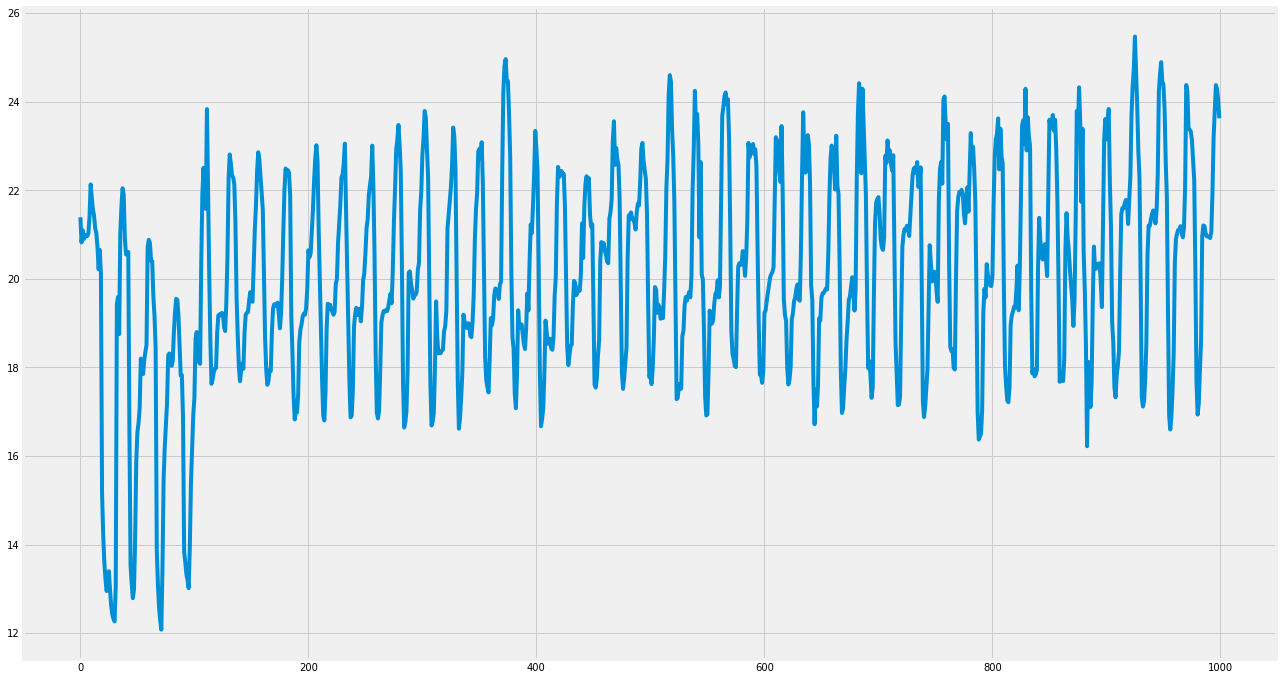

In [43]:
whole_df['Tair'][:1_000].plot(figsize=(20, 12))

In [73]:
df = whole_df.loc[:, ['time', 'Tair']].rename(columns={'time': 'ds', 'Tair': 'y'})

In [60]:
model = Prophet(weekly_seasonality=False, interval_width=0.95)

In [61]:
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -25.0512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10300.7     0.0111439        1764.1      0.3729           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10319.5   0.000897444       222.126           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10324    0.00131037       181.384      0.8045      0.8045      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       10324.5   3.76522e-05       121.262    3.91e-07       0.001      515  LS failed, Hessian reset 
     399       10324.6   5.66775e-06        60.397   1.057e-07       0.001      583  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     419       1

06156      0.2678      614   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


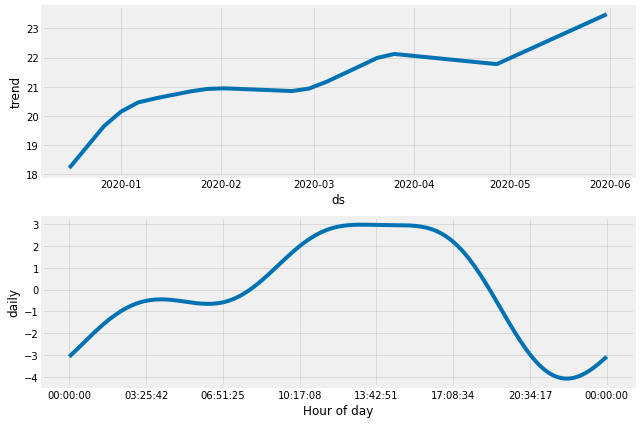

In [62]:
future = model.make_future_dataframe(periods=24, freq='H')
forecasts = model.predict(future)
model.plot_components(forecasts);

In [ ]:
df_cv = cross_validation(model, parallel='processes', initial='3700 hours', horizon='24 hours', period='24 hours');

In [64]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-19 00:00:00,18.960971,16.223546,21.671175,18.475000,2020-05-18 23:00:00
1,2020-05-19 01:00:00,19.981934,17.064177,22.722707,18.623077,2020-05-18 23:00:00
2,2020-05-19 02:00:00,20.879895,18.126463,23.747585,19.463636,2020-05-18 23:00:00
3,2020-05-19 03:00:00,21.468382,18.676741,24.281126,19.750000,2020-05-18 23:00:00
4,2020-05-19 04:00:00,21.680767,18.878217,24.392657,20.123077,2020-05-18 23:00:00
...,...,...,...,...,...,...
259,2020-05-29 19:00:00,23.015762,19.934588,25.926452,26.084615,2020-05-28 23:00:00
260,2020-05-29 20:00:00,21.294592,18.255053,24.104502,22.363636,2020-05-28 23:00:00
261,2020-05-29 21:00:00,19.963930,16.793870,23.152892,19.825000,2020-05-28 23:00:00
262,2020-05-29 22:00:00,19.380248,16.309087,22.488567,18.530769,2020-05-28 23:00:00


In [66]:
df_p1 = performance_metrics(df_cv)
df_p1.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 03:00:00,4.345274,2.084532,1.871220,0.097022,0.097954,0.092157,0.884615
1,0 days 04:00:00,5.200849,2.280537,2.071549,0.105279,0.102057,0.099295,0.793706
2,0 days 05:00:00,5.909014,2.430846,2.219437,0.111473,0.115507,0.104660,0.741259
3,0 days 06:00:00,6.261375,2.502274,2.292945,0.114890,0.115751,0.107674,0.727273
4,0 days 07:00:00,5.447567,2.334002,2.122007,0.105547,0.115612,0.099423,0.804196


In [77]:
no_na_df = whole_df.dropna()

selector = RFE(Ridge(), n_features_to_select=3)
selector.fit(no_na_df[cols_2], no_na_df['Tair']);

In [85]:
model = Prophet(weekly_seasonality=False, interval_width=0.95)

df =  no_na_df.loc[:, ['time', 'Tair']].rename(columns={'time': 'ds', 'Tair': 'y'})

for feature in selector.get_feature_names_out():
    df[feature] = no_na_df[feature]
    model.add_regressor(feature)
    
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/mahyar/Works/ShittyStuff/TS/venv/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -33.0434


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12337.8    0.00120216       796.278      0.7097      0.7097      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         12344   0.000170502       131.252           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12345.8    0.00338275       685.138           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12348.6    0.00188567       512.627           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       12350.3   0.000451509       278.554      0.4357      0.4357      574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [ ]:
df_cv = cross_validation(model, parallel='processes', initial='3700 hours', horizon='24 hours', period='24 hours');
df_p2 = performance_metrics(df_cv)

In [94]:
pd.concat([df_p1.mean()[1:], df_p2.mean()[1:]], axis=1).rename(columns={0: 'naive', 1: 'regressors'})

,naive,regressors
mse,9.380771,1.156189
rmse,2.802414,1.011052
mae,2.339779,0.741367
mape,0.095248,0.03402
mdape,0.086298,0.022489
smape,0.098629,0.0334
coverage,0.699619,0.852679


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.95% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.95% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 131
INFO:NP.config:Auto-set epochs to 131
100%|█████████

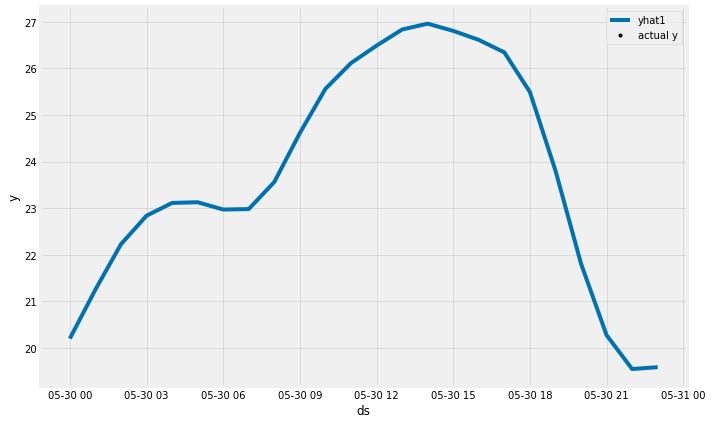

In [98]:
model = NeuralProphet(weekly_seasonality = False)

df = whole_df.loc[:, ['time', 'Tair']].rename(columns={'time': 'ds', 'Tair': 'y'})

model.fit(df, freq="H")

future = model.make_future_dataframe(df, periods=24)
forecasts = model.predict(future)
fig = model.plot(forecasts)